# Spring 2020 - IEOR4718 - Prof. Emanuel Derman

# Binomial Trees Using Object Oriented Programming


Binomial Trees are an important part of derivative valuation. It provides at extremely easy way to price path-dependent options, and in particular options with possible early exercise such as American Calls and Puts. The model is also very intuitive. All in all Binomial Models are very flexible and useful in practice. 

In this notebook we will tackle how to use Object Oriented Programming to implement a Binomial Tree Class for constant volatility. Much of these classes are inspired by *C++ Design Patterns and Derivatives Pricing* by Mark Joshi.

We will see how to extend this implementation in the case of volatility with time and stock's level dependence. These models are called **Local Volatility Models**.


## Table of Content

1. Imports
2. Tree Option Classes: classes that make the pricing of derivatives easy on trees only
    1. Abstract Class
    2. European Options
    3. American Options
3. A Tree Class with constant volatility
4. How to use this class?
    1. European vs American Call Valuation
    2. Time Complexity and Accuracy of the valuation (vs. BSM model)




## Imports

In [1]:
import numpy as np
import pandas as pd
import time
import BSM as bsm
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use("seaborn")

## Tree Option Classes

Pricing options on trees has little to do with general option concepts using elsewhere. The most important difference is the need of a *valueAtNode* function, which, given the spot price, the current time and the future discounted value of the option, compute the value of the option at a given node. 

Therefore, TreeOption classes are implemented, which will make the pricing of options easy on any tree. 

The design is inspried by Mark Joshi, which allows any option. Not only traditional European and American options, but exotic one as well, say a Barrier Option that can be exercised only but only in a specific timeframe. 

### Abstract Class

In [2]:
class TreeAbstractOption:
    
    def __init__(self, maturity, payoff):
        
        self.T = maturity
        self.payoff = payoff
        
    
    def valueAtNode(self, time, spot, discountedFutureValue):
        pass

### European Tree Options

In [3]:
class TreeEuropeanOption(TreeAbstractOption):
    
    def __init__(self, maturity, payoff):
        
        TreeAbstractOption.__init__(self, maturity, payoff)
        
    
    def valueAtNode(self, time, spot, discountedFutureValue):
        
        return discountedFutureValue

### American Tree Options

In [4]:
class TreeAmericanOption(TreeAbstractOption):
    
    def __init__(self, maturity, payoff):
        
        TreeAbstractOption.__init__(self, maturity, payoff)
    
    
    def valueAtNode(self, time, spot, discountedFutureValue):

        return max(self.payoff(spot), discountedFutureValue)

## A Tree Class with constant volatility

In the most simple case, we take $\sigma=constant$. It gives us the following class:

In [5]:
class ConstantVolTree:
    
    def __init__(self, spot, rates, dividends, volatility, n_steps, maturity):
        
        self.spot = spot
        self.r = rates
        self.q = dividends
        self.vol = volatility # annualized vol
        self.N = n_steps
        self.T = maturity
        
        self.dt = maturity / n_steps
        self.std = volatility * np.sqrt(self.dt)
        
        self.hasBeenBuilt = False
    
    
    def _build(self):
        
        # TODO: allow rate and dividend curve
        self.discounts = np.exp( - self.r * self.dt ) * np.ones(self.N+1) 
        
        self.treeStock = np.zeros( (self.N+1, self.N+1) )
        self.treeOption = np.zeros( (self.N+1, self.N+1) )
        
        movedLogSpot = np.log(self.spot)
        
        self.treeStock[0, 0] = np.log(self.spot)
        
        for i in range(1, self.N+1):
            
            movedLogSpot += (self.r - self.q - self.vol**2 / 2) * self.dt
            
            k = 0
            for j in range(-i, i+1, 2):
                
                self.treeStock[i, k] = movedLogSpot + j * self.std
                k += 1
            
        self.treeStock = np.exp( self.treeStock )
        self.hasBeenBuilt = True
    
    
    def getValue(self, option:TreeAbstractOption):
        
        if not(self.hasBeenBuilt):
            self._build()

        # Initialization: at maturity it's only the final payoff
        for k in range(0, self.N+1):
            self.treeOption[self.N, k] = option.payoff( self.treeStock[self.N, k] )
        
        # Backward Induction
        for i in range(self.N-1, -1, -1):
            
            t = i * self.dt
            
            for k in range(0, i+1):
                
                spot = self.treeStock[i, k]
                discountedFutureValue = self.treeOption[i+1, k] + self.treeOption[i+1, k+1]
                discountedFutureValue *= 0.5 * self.discounts[i]
               
                self.treeOption[i, k] = option.valueAtNode(t, spot, discountedFutureValue)
        
        return self.treeOption[0, 0]

In [6]:
def printTree(which, TREE):
    
    if which in ["s", "stock"]:
        df = pd.DataFrame( TREE.treeStock )
    elif which in ["o", "option"]:
        df = pd.DataFrame( TREE.treeOption )
    
    df.index *= TREE.dt
    
    for i in range(len(df)):
        for j in range(i+1, len(df[0])):
            df.iloc[i, j] = np.nan
    
    return df.round(2)

## Example

### Value of Options

In [7]:
callP = lambda x : max(0, x - 100)
call = TreeEuropeanOption(1, callP)
Acall = TreeAmericanOption(1, callP)

tree = ConstantVolTree(100, 0.1, 0.08, 0.25, 10, 1)

valueEuropean, valueAmerican = tree.getValue(call), tree.getValue(Acall)

print(" - The value of an European call option struck at 100 is approximately ${:.2f}".format(valueEuropean))
print(" - The value of an American call option struck at 100 is approximately ${:.2f}".format(valueAmerican))

 - The value of an European call option struck at 100 is approximately $9.92
 - The value of an American call option struck at 100 is approximately $9.98


### Stock Tree

In [8]:
printTree("stock", tree)

,0,1,2,3,4,5,6,7,8,9,10
0.0,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.1,92.29,108.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.2,85.18,99.78,116.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.3,78.62,92.09,107.86,126.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.4,72.56,84.99,99.55,116.60,136.58,NaN,NaN,NaN,NaN,NaN,NaN
0.5,66.97,78.44,91.88,107.62,126.05,147.65,NaN,NaN,NaN,NaN,NaN
0.6,61.81,72.40,84.80,99.33,116.34,136.27,159.61,NaN,NaN,NaN,NaN
0.7,57.05,66.82,78.27,91.67,107.38,125.77,147.32,172.55,NaN,NaN,NaN
0.8,52.65,61.67,72.24,84.61,99.10,116.08,135.97,159.26,186.54,NaN,NaN
0.9,48.60,56.92,66.67,78.09,91.47,107.14,125.49,146.98,172.16,201.65,NaN


### European Call Option's Valuation Tree

In [9]:
tree.getValue(call)
printTree("option", tree)

,0,1,2,3,4,5,6,7,8,9,10
0.0,9.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.1,5.76,14.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.2,2.84,8.80,20.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.3,1.07,4.67,13.12,27.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.4,0.23,1.92,7.51,18.99,36.33,NaN,NaN,NaN,NaN,NaN,NaN
0.5,0.00,0.47,3.41,11.75,26.62,46.77,NaN,NaN,NaN,NaN,NaN
0.6,0.00,0.00,0.95,5.94,17.80,35.97,58.51,NaN,NaN,NaN,NaN
0.7,0.00,0.00,0.00,1.92,10.08,25.88,46.78,71.41,NaN,NaN,NaN
0.8,0.00,0.00,0.00,0.00,3.88,16.49,35.79,58.71,85.55,NaN,NaN
0.9,0.00,0.00,0.00,0.00,0.00,7.83,25.48,46.81,71.79,101.04,NaN


### American Call Option's Valuation Tree

In [10]:
tree.getValue(Acall)
printTree("option", tree)

,0,1,2,3,4,5,6,7,8,9,10
0.0,9.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.1,5.78,14.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.2,2.84,8.83,20.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.3,1.07,4.67,13.17,27.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.4,0.23,1.92,7.52,19.09,36.85,NaN,NaN,NaN,NaN,NaN,NaN
0.5,0.00,0.47,3.41,11.78,26.79,47.65,NaN,NaN,NaN,NaN,NaN
0.6,0.00,0.00,0.95,5.94,17.85,36.28,59.61,NaN,NaN,NaN,NaN
0.7,0.00,0.00,0.00,1.92,10.08,25.97,47.32,72.55,NaN,NaN,NaN
0.8,0.00,0.00,0.00,0.00,3.88,16.49,35.97,59.26,86.54,NaN,NaN
0.9,0.00,0.00,0.00,0.00,0.00,7.83,25.49,46.98,72.16,101.65,NaN


## European Call Option Valuation's Speed and Accuracy with #steps

In [12]:
nSteps = [10, 100, 500, 1000, 2500, 5000, 7500, 10000]

speed = list()
accuracy = list()
relativeAccuracy = list()

spot = 100
strike = 100
rates = 0.1
dividends = 0.08
vol = 0.25
maturity = 1

call = TreeEuropeanOption(1, lambda S : max(0, S - strike))
BSMprice = bsm.call.price(spot, strike, 0, maturity, vol, rates, dividends)

for n in nSteps:
    
    print(" - Tree model with {} steps".format(n))
    
    tree = ConstantVolTree(spot, rates, dividends, vol, n, maturity)
    
    t0 = time.time()
    approxValue = tree.getValue(call)
    
    speed.append( time.time() - t0 )
    accuracy.append(np.abs( approxValue - BSMprice ) )
    relativeAccuracy.append(np.abs( approxValue - BSMprice ) / BSMprice )

 - Tree model with 10 steps
 - Tree model with 100 steps
 - Tree model with 500 steps
 - Tree model with 1000 steps
 - Tree model with 2500 steps
 - Tree model with 5000 steps
 - Tree model with 7500 steps
 - Tree model with 10000 steps


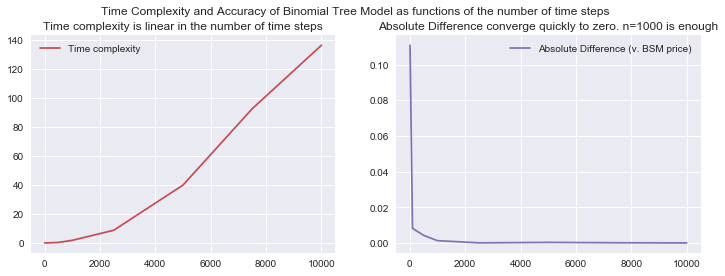

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

fig.suptitle("Time Complexity and Accuracy of Binomial Tree Model as functions of the number of time steps")

ax1.plot(nSteps, speed, color='C2', label="Time complexity")
ax1.set_title("Time complexity is linear in the number of time steps")
ax1.legend()

ax2.plot(nSteps, accuracy, color='C3', label="Absolute Difference (v. BSM price)")
ax2.set_title("Absolute Difference converge quickly to zero. n=1000 is enough")
tmp = ax2.legend()